# <center/> Evaluation Metrics, PCA, and Feature Transformations </center>

In this lab we'll discuss evaluation metrics for classification, principal component analysis, and feature transformations. By the end of this lab, you should:
- Be familiar with precision, recall, precision-recall curves, and ROC curves
- Understand what PCA does
- Understand why it can be important to standardize features

## 1 Evaluation metrics
In this section we discuss precision, recall, precision-recall curves, and ROC curves.

### 1.1 Precision and Recall
Two common methods for evaluating the performance of a classifier on a single class are the precision and recall. Precision is defined as 
$$ \text{Precision} = \frac{\text{# True positives}}{\text{# True positives + # False positives}} $$
and recall is defined as 
$$ \text{Recall} = \frac{\text{# True positives}}{\text{# True positives + # False negatives}}. $$
Suppose we want to identify whether an image contains a toucan (1) or not (0). Then in this case the true positives are the images that contain toucans, the false positives are the images our classifier labeled as having a toucan that in fact did not have a toucan, and the false negatives are the images our classifier labeled as not having a toucan that did in fact have a toucan.

A pictorial description is below. Continuing with the above example, in the picture "positive images" would represent the images containing toucans. The "returned images" would be the images that our classifier labeled as having a toucan.

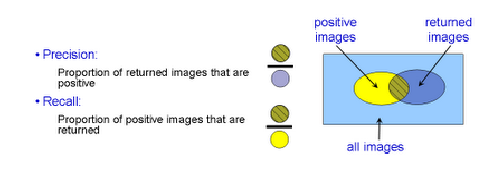

In [1]:
from io import BytesIO
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image, ImageOps 
import requests

def display_image(url, figsize):
    response = requests.get(url)
    pca_figure = Image.open(BytesIO(response.content))
    fig, ax = plt.subplots(figsize=figsize)
    fig = ax.imshow(np.asarray(pca_figure), aspect='auto')
    plt.axis('off')
    plt.show()

url = 'http://www.di.ens.fr/willow/events/cvml2013/materials/practicals/category-level-recognition_files/pr1.png'
figsize = (399/50, 137/50)
display_image(url, figsize)

** Exercise 1 ** Suppose we classified 10 images, that we know their true labels, and that the results are in the following table:
<pre>
Image #:         |  1 |  2 |  3 |  4 |  5 |  6 |  7 |  8 |  9 | 10 |
True label:      | +1 | +1 | -1 | -1 | +1 | -1 | +1 | -1 | -1 | -1 |
Classifier label:| -1 | +1 | -1 | -1 | +1 | +1 | +1 | +1 | -1 | -1 |
</pre>
Compute the following:
- Number of true positives
- Number of true negatives
- Number of false positives
- Number of false negatives
- Precision
- Recall

Let's return to the toucan vs. hornbill example from last week. Again, change `data_dir` if necessary.

In [2]:
import os
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV

data_dir = 'lab3_data'

# Load the data
x_train = np.load(os.path.join(data_dir, 'train_features.npy'))
y_train = np.load(os.path.join(data_dir, 'train_labels.npy'))
x_test = np.load(os.path.join(data_dir, 'val_features.npy'))
y_test = np.load(os.path.join(data_dir, 'val_labels.npy'))

# Standardize the data
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# Train the classifier
classifier = LogisticRegressionCV()
classifier.fit(x_train, y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

** Exercise 2 ** Compute the precision and recall for the toucan class (without using the sklearn.metrics.precision_score function). Then you can check your code with the code below. 

In [6]:
# Generate predictions based on a threshold of a probability of 0.5
yhat_test = classifier.predict(x_test)

# Compute precision and recall
precision = sum(((y_test == 1) & (yhat_test == 1)))/sum(yhat_test == 1) #sum(np.bitwise_and(y_test == 1, yhat_test == 1))/sum(yhat_test == 1)
print('Precision = %0.2f' % precision)
recall = sum(np.bitwise_and(y_test == 1, yhat_test == 1))/sum(y_test == 1)
print('Recall = %0.2f' % recall)

Precision = 0.91
Recall = 0.84


In [4]:
import sklearn.metrics

precision_sklearn = sklearn.metrics.precision_score(y_test, yhat_test)
print('Precision according to sklearn = %0.2f' % precision_sklearn)
recall_sklearn = sklearn.metrics.recall_score(y_test, yhat_test)
print('Recall according to sklearn = %0.2f' % recall_sklearn)

Precision according to sklearn = 0.91
Recall according to sklearn = 0.84


Of the images we labeled as having toucans, 91% of them did in fact have a toucan. Out of all of the images with toucans, we only labeled 84% of them as having toucans.

### 1.2 Precision-Recall curve
Logistic regression classifiers output a continuous value, and we convert that to $\pm$ 1 (or 1/0) by applying a threshold. Depending on how you set the threshold, you'll get different precision and recall values. In some applications it's very important to have either high precision or high recall. A classic statistical example of this is when trying to assess whether or not people are guilty of a crime. It's terrible to convict an innocent person of a crime, so we would want to have very few (hopefully zero) false positives and aim for very high precision.

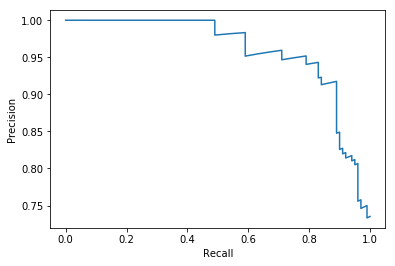

In [10]:
# We can plot a curve of precision and recall values as we change the threshold for what we
# use to assign an image to the toucan class vs. the non-toucan (hornbill) class.
from sklearn.metrics import precision_recall_curve

# Generate estimated values for test observations using the logistic regression classifier
test_probs = classifier.predict_proba(x_test)

precision, recall, thresholds = precision_recall_curve(y_test, test_probs[:, 1])
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

### 1.3 ROC Curve
Another common way to summarize the results is via a receiver operating characteristic (ROC) curve. An ROC curve plots the true positive rate vs. the false positive rate as the threshold is varied. Here we have
$$ \text{True positive rate} = \text{Recall} = \frac{\text{# True positives}}{\text{# True positives + # False negatives}} $$
and
$$ \text{False positive rate} = \frac{\text{# False positives}}{\text{# False positives + # True negatives}}. $$

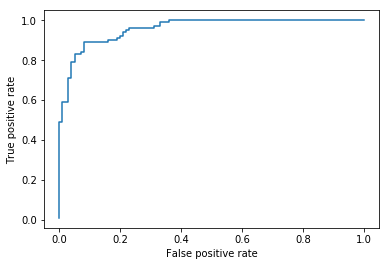

In [11]:
# We can plot a curve of precision and recall values as we change the threshold for what we
# use to assign an image to the toucan class vs. the non-toucan (hornbill) class.
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(y_test, test_probs[:, 1])
plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

Sometimes people give a one-number summary of the above plot called the area under the curve (AUC). The AUC is exactly what it sounds like: the area under the curve above.

In [12]:
# Compute the AUC
roc_auc_score(y_test, test_probs[:, 1])

0.95799999999999996

** Exercise 3 ** Find the value of the threshold that gives a false positive rate of at most 1%. Hint: Use the `fpr` and `thresholds` variables we already have.

In [16]:
idx = max(np.where(fpr <= 0.01)[0])
thresholds[idx]

0.97058675011236784

When would you use a precision-recall curve vs. an AUC curve? Suppose your data is skewed and that the number of true negatives is huge (compared to the false positives). Then the ROC curve would lie in the very upper left corner of the plot (It doesn't take into account class imbalance). This would be the case in e.g., web search results. However, as the number of true negatives is not taken into account for the precision-recall curve, the precision-recall curve wouldn't necessarily lie in the very upper right part of its plot. On the other hand, if you care about how the model performs on both the positive and negative classes (e.g., classifying toucans vs. hornbills), you're better off using AUC.

## 2 Principal component analysis (PCA)
Principal component analysis (PCA) is a method that is used to transform a set of variables into a smaller set of variables that explain most of the variability in the original dataset. PCA has no response variable, so it is an "unsupervised" learning method. 

Why would we want to use such a method? It can be useful for data compression and visualization, and the results can also be used in other downstream tasks, such as regression, classification, and clustering. Using the results from PCA instead of the original features often leads to less noisy results, as the first few principal components  tend to contain the signal in data (as opposed to the noise). One downside is that after applying PCA, the regression and classification coefficients often become uninterpretable.

In this lab we'll see how to run PCA on a dataset of faces.

### 2.1 PCA overview
The goal of PCA is to project a dataset consisting of observations $x_1,\dots, x_n \in \mathbb{R}^D$ onto a lower dimensional subspace of dimension $M$ such that we maximize the variance of the projected data. An equivalent way of viewing PCA is that we are projecting the data onto a subspace that is "closest" to the observations. If we try to reconstruct the original data from the data projected using PCA, we will get the "best" possible reconstruction. All of this may sound confusing, so let's look at a couple of pictures.

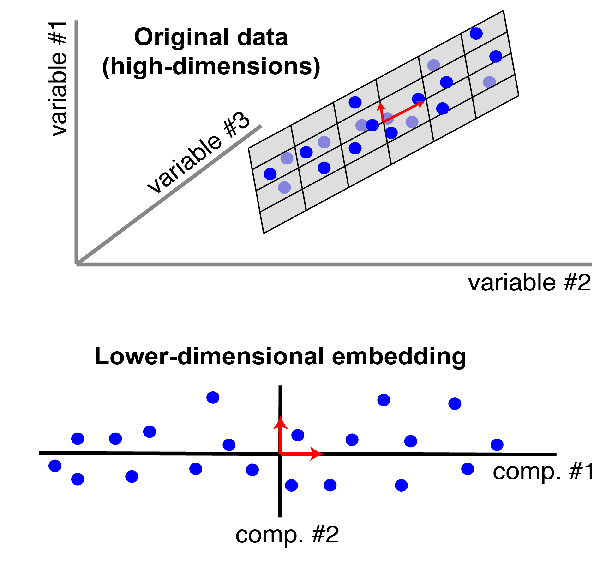

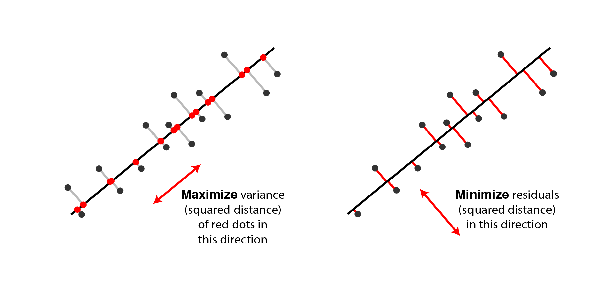

In [17]:
from io import BytesIO
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image, ImageOps  # PIL is the Python Imaging Library
import requests

image_url1 = 'http://alexhwilliams.info/itsneuronalblog/img/pca/pca_classic.png'
image_url2 = 'http://alexhwilliams.info/itsneuronalblog/img/pca/pca_two_views.png'
for i in range(0, 2):
    image_url = image_url1 if i==0 else image_url2
    response = requests.get(image_url)
    pca_figure = Image.open(BytesIO(response.content))
    if i == 0:
        fig, ax = plt.subplots(figsize=(10, 10))
    else:
        fig, ax = plt.subplots(figsize=(10, 5))
    fig = ax.imshow(np.asarray(pca_figure), aspect='auto')
    plt.axis('off')
    plt.show()

In the first picture, we have three-dimensional data ($D=3$) and each blue point is an observation. When using PCA to reduce this data to two dimensions, we find the plane that is closest to the data. Equivalently, we find the directions that capture the largest amount of the variance in the data and such that the directions are orthogonal. The red arrows represent the directions with the largest variance.

In the picure at the bottom there are $n=16$ observations $x_1,\dots, x_{16}$ (the gray points), each with $D=2$ dimensions. The image shows the results of running PCA on these observations. The direction with the maximum variation in the data is denoted by the black line. Hence, if we project the data down to one dimension, we will maximize the variance of the projected data if we project along this axis. Equivalently, the distance between the points and a subspace (a line) is at a minimum if we choose the line to be the black line in the picture. The red points are the values of the observations after they were projected onto the first principal component $v_1$. 

A note on terminology before continuing: Some references call $v_1$ a principal component, whereas others call $Xv_1$ a principal component. 

Now let's briefly look at the math behind PCA. This section is based off of the notes from here: 
http://www.cs.columbia.edu/~stratos/research/pca_cca.pdf

Let $X\in\mathbb{R}^D$ be a random variable. Without loss of generality assume it has a mean of zero. The goal is to find a lower dimensional random variable $X'=(X'_1, \dots, X'_M)\in\mathbb{R}^M$ such that each successive element $X_i'\in\mathbb{R}$ has as much variance as possible and is uncorrelated with the previous values. In other words, for $i=1,\dots, M$, we solve the following problem:
$$ X_i' = \arg\max_{\Psi}\text{Var}(\Psi)$$
subject to the constraint that $\Psi=v^TX$ for some vector $v\in\mathbb{R}^D$ with $\|v\|^2=1$ and such that 
$$ \text{Corr}(\Psi, X'_j) = 0$$
for $j=1,\dots, i-1$. We require $\|v\|^2=1$ because otherwise we could make $\text{Var}(v^TX)$ arbitrarily large. 

Let $v_1,\dots, v_M$ be the optimal values of $v$ from above. The PCA projections are given by $\Psi = V^TX$, where $V=[v_1,\dots, v_M]$.

It turns out that $v_1,\dots, v_M$ are the eigenvectors corresponding to the $M$ largest eigenvalues of the covariance matrix of $X$, $E[XX^T]$. Moreover, the amount of variance explained by each component is the eigenvalue corresponding to that component.

In practice we don't have a random variable; we have samples $x_1,\dots, x_n$. Therefore, we estimate the covariance matrix with the empirical covariance matrix. The resulting PCA algorithm proceeds as follows:
> INPUT: Samples $x_1,\dots, x_n\in\mathbb{R}^D$ and an integer $M\leq D$
> 1. Compute $\hat\mu\in\mathbb{R}^D$ where $\hat\mu_i = \frac{1}{n}\sum_{k=1}^n x_{k,i}$ for $i=1,\dots,D$. Let $Z=[z_1,\dots,z_n]\in\mathbb{R}^{D\times N}$ where
> $$z_k = x_k - \hat\mu \:.$$
> 2. Set $\hat C_{XX} = \frac{1}{N}ZZ^T\in\mathbb{R}^{D\times D}$.
> 3. Compute $\hat V_M = \text{Matrix of eigenvectors corresponding to the top $M$ eigenvalues of $\hat C_{XX}$}$.
> 4. Compute ${x}'_{1},\dots, x'_N\in\mathbb{R}^M$, where
> $$ x'_{k} = \hat V_m^T z_k \:.$$  
>
> OUTPUT: Samples $x'_1,\dots, x'_n\in\mathbb{R}^M$

To convert a projected point $x'_k$ to the original space, we need to use apply $\hat V_M$, to $x'_k$ and add the mean of the $x_i$'s:
$$ \hat x_k = \hat V_M x'_k + \hat\mu$$
($\hat V_M$ is the same as the pseudo-inverse of $\hat V_M^T$.)

The main takeaways from above are:
1. The eigenvectors of the empirical covariance matrix corresponding to the top $M$ eigenvalues tell us how to project the data onto an $M$-dimensional space.
2. The variance of the $k$th coordinate of the projected data is given by the $k$th largest eigenvalue.

If you want to read more about PCA, two nice references are:
- Section 12.1 in Pattern Recognition and Machine Learning by Christopher Bishop
- This note by Karl Stratos: http://www.cs.columbia.edu/~stratos/research/pca_cca.pdf


### 2.2 A simple example
Consider data $x_1=(1, 0)$, $x_2=(0,1)$, and $x_3=(-4, -4)$. We will perform PCA on this very small dataset to reduce it from two dimensions to one dimension. First though let's plot the data.

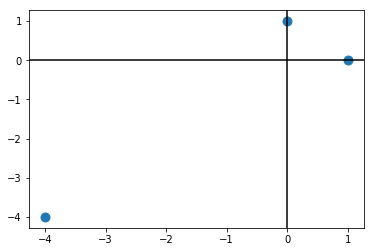

In [18]:
X = np.array([[1, 0], [0, 1], [-4, -4]])
fig, ax = plt.subplots()
plt.scatter(X[:, 0], X[:, 1], s=80)
ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')
plt.show()

Perhaps you can already tell what the first principal component is. Regardless, we are going to calculate it by hand.

** Exercise 4 ** Compute the empirical covariance matrix $\hat C_{XX}$. This is steps 1 and 2 above.

** Exercise 5 ** Compute the eigenvalues and eigenvectors of $\hat C_{XX}$. 

** Exercise 6 ** Compute the PCA projections of $x_1$, $x_2$, and $x_3$ onto a 1-dimensional space (a line).

** Exercise 7 ** Convert $x_1'$, $x_2'$, and $x_3'$ back to the original space using the top principal component. This is the best estimate you can have of $x_1$, $x_2$, and $x_3$ when you only know $x_1'$, $x_2'$, $x_3'$, $\hat\mu$, and $v_1$.

### 2.3 Example data
For this part of the lab we are going to use images of people's faces from the Faces in the Wild dataset (http://vis-www.cs.umass.edu/lfw/ ). The data may take several minutes to download.

In [19]:
%matplotlib inline 

import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_lfw_people

faces = fetch_lfw_people(min_faces_per_person=30) 
print('People in the dataset:', faces.target_names)  # Images of 34 different people
print('Dimensions of data:', faces.images.shape)  # 2370 images, each of which is 62x47 pixels
print('Dimension of unraveled data:', faces.data.shape)    # Each image is unraveled to a vector of size 2914

People in the dataset: ['Alejandro Toledo' 'Alvaro Uribe' 'Andre Agassi' 'Ariel Sharon'
 'Arnold Schwarzenegger' 'Colin Powell' 'David Beckham' 'Donald Rumsfeld'
 'George W Bush' 'Gerhard Schroeder' 'Gloria Macapagal Arroyo'
 'Guillermo Coria' 'Hans Blix' 'Hugo Chavez' 'Jacques Chirac'
 'Jean Chretien' 'Jennifer Capriati' 'John Ashcroft' 'John Negroponte'
 'Junichiro Koizumi' 'Kofi Annan' 'Laura Bush' 'Lleyton Hewitt'
 'Luiz Inacio Lula da Silva' 'Megawati Sukarnoputri' 'Nestor Kirchner'
 'Recep Tayyip Erdogan' 'Roh Moo-hyun' 'Serena Williams'
 'Silvio Berlusconi' 'Tom Ridge' 'Tony Blair' 'Vicente Fox'
 'Vladimir Putin']
Dimensions of data: (2370, 62, 47)
Dimension of unraveled data: (2370, 2914)


Let's take a closer look at the data before doing anything else.

In [20]:
X = faces.data
print('Mean of first ten features: \n', X.mean(axis=0)[0:10])

Mean of first ten features: 
 [  85.51311493   88.53321075   94.07670593  101.95379639  110.9405365
  119.3740387   127.08486176  133.85165405  139.75683594  144.70924377]


In [21]:
print('Variance of first ten features:\n', X.var(axis=0)[0:10,])

Variance of first ten features:
 [ 2560.23510742  2478.91235352  2424.53686523  2419.63647461  2408.43481445
  2359.89672852  2198.31518555  2044.37402344  1930.38476562  1813.36010742]


In [22]:
print('Min of first ten features:', X.min(axis=0)[0:10])
print('Max of first ten features:', X.max(axis=0)[0:10])

Min of first ten features: [ 0.          0.          0.          0.66666669  1.          1.66666663
  2.66666675  2.33333325  4.66666651  9.33333302]
Max of first ten features: [ 254.33332825  254.33332825  254.          253.66667175  253.33332825
  253.33332825  254.          254.33332825  252.66667175  252.33332825]


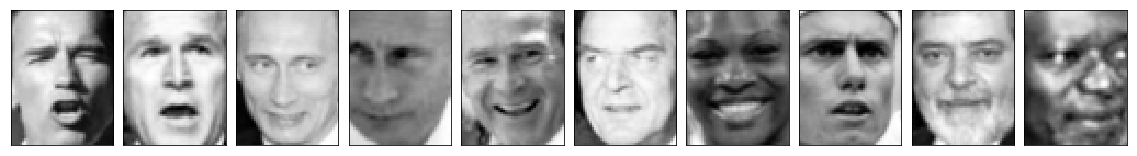

In [29]:
# Look at some of the faces
fig, ax = plt.subplots(1, 10, figsize=(20, 5),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))
start = 700
for i in range(start, start+10):
    ax[i-start].imshow(X[i, :].reshape(62, 47), cmap='Greys_r')
plt.show()

** Exercise 8 ** Compute the "average" face.

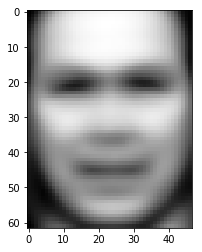

In [30]:
mean_face = np.mean(X, axis=0)
plt.imshow(np.reshape(mean_face, [62, 47]), cmap='Greys_r')

If one feature has a much higher variance than the other features, it will have a very large influence on the principal components. If we don't want this to occur, then prior to performing PCA we should standardize the variables to have a mean of zero and a standard deviation of 1. In our case we will not divide by the standard deviation because the features are already normalized to be between 0 and 255.

### 2.4 PCA with scikit-learn
Let's try running PCA with scikit-learn. By default, scikit-learn will use the randomized PCA version since the dimensions of the data are so large. 

** Exercise 9 ** Use scikit-learn's `PCA` to run PCA on our data with 200 components. Call the PCA object `pca` and recall that our data is stored in `X`.

In [33]:
from sklearn.decomposition import PCA
pca = PCA(n_components=200)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=200, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

The PCA class has several important attributes and methods. The attributes that are relevant to us are:
- components_ : "Principal axes in feature space, representing the directions of maximum variance in the data. The components are sorted by explained\_variance\_."
- explained_variance\_ratio\_ : "Percentage of variance explained by each of the selected components."

Let's look at the first few principal components. Recall that the first principal component $v_1$ is the direction that captures the most variance. The second principal component $v_2$ is the direction that is orthogonal to the first direction and captures as much variance as possible, etc. Each principal component is orthogonal to the previous components. Normally we can't visualize the principal components because they're high-dimensional vectors. But with images we can!

In [34]:
# Before we visualize the eigenvectors (here called "eigenfaces"), remember that they're just vectors:
print('First principal component:', pca.components_[0])

First principal component: [-0.00577266 -0.00646468 -0.00748304 ..., -0.00745935 -0.00628186
 -0.00536242]


This vector is the analogue of the eigenvector [1,1] that we found in the simple example from Section 2.2.

** Exercise 10 ** Visualize the principal components by substituting the relevant code into the last line below.

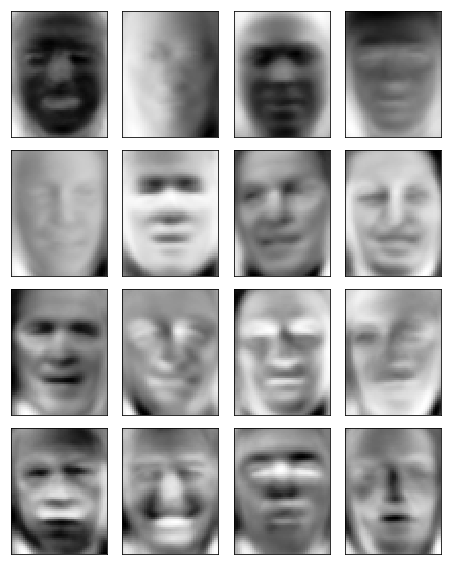

In [35]:
# But if we reshape the principal components, we can visualize them
fig, axes = plt.subplots(4, 4, figsize=(10, 10), subplot_kw={'xticks':[], 'yticks':[]},
                        gridspec_kw={'hspace': 0.1, 'wspace': -0.5})
for i, ax in enumerate(fig.axes):
    # Replace np.zeros(62*47) with principal component i below 
    ax.imshow(np.reshape(pca.components_[i], (62, 47)), cmap='Greys_r')

The first few principal components here (top row) capture the differences in the lighting across the images. Others seem to capture the variation in the eyes, noses, and facial hair.

#### How many principal components?
One question we need to answer is "How many principal components should we use?" We want enough principal components to capture most of the variation in the data, but not too many. This tends to be a problem- and data-specific question. If we're performing PCA for use in a supervised learning task, then we can use cross-validation to choose the best number of components. Other ways that are ad-hoc include:
- Choosing the smallest number of components such that a certain percentage of the variance is retained (e.g., 95%)
- Looking at what's called a "scree plot", which is a plot of the percent of variance captured by each principal component. The "elbow" method looks at where there plot goes from having a steep slope to being relatively flat and takes the point just before that occurs to be the number of principal components to use.

Let's see how we could go about using the latter two methods:

** Exercise 11 ** How much variance is explained by the first 25 principal components? How many components are necessary to capture 95% of the variance in the data? 
Hint: `pca.explained_variance_ratio_` contains the percent of variance explained by each component.

In [36]:
pca.explained_variance_ratio_

array([ 0.2143696 ,  0.12697987,  0.07173216,  0.06515004,  0.04315343,
        0.02992254,  0.02129804,  0.01892708,  0.01819372,  0.01631981,
        0.015859  ,  0.01408804,  0.01268123,  0.01111337,  0.01078013,
        0.00975958,  0.00939829,  0.00856463,  0.00772308,  0.00718536,
        0.00634594,  0.0062059 ,  0.0057405 ,  0.00541011,  0.00500427,
        0.00499332,  0.00481067,  0.00463104,  0.00449773,  0.00426754,
        0.00402076,  0.00374776,  0.00347139,  0.00345873,  0.00323361,
        0.00320228,  0.00304049,  0.00301255,  0.00297271,  0.00287803,
        0.0027529 ,  0.00272326,  0.00269909,  0.0026532 ,  0.00246141,
        0.0024475 ,  0.00241063,  0.00236099,  0.00232722,  0.00223287,
        0.00220012,  0.0021291 ,  0.00209508,  0.00200183,  0.00197333,
        0.00195199,  0.00190164,  0.00187042,  0.00176252,  0.00171709,
        0.00169174,  0.00165239,  0.00162124,  0.0015654 ,  0.00154956,
        0.001522  ,  0.00150795,  0.00143936,  0.00142987,  0.00

In [37]:
print('Variance explained by first 25:', sum(pca.explained_variance_ratio_[0:25]))

Variance explained by first 25: 0.76190572558


In [45]:
cumsum = np.cumsum(pca.explained_variance_ratio_)
print(min(np.where(cumsum > 0.95)[0]+1), 'components required to capture 95% of the variance')

171 components required to capture 95% of the variance


** Exercise 12 ** Plot the percent of variance explained by each component vs. the component number. Based on the elbow method heuristic, how many principal components would you choose?

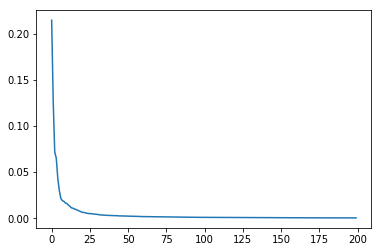

In [46]:
plt.plot(pca.explained_variance_ratio_)

Let's see what happens if we keep only the first 25 principal components. We'll first project the images down to 25 dimensions (the projected space). There are three ways to do this:
- "By hand", using the fact that the projected values are just the matrix of eigenvectors times the matrix of features
- Using the `transform()` method in sklearn after setting the PCA algorithm to find the top 25 components
- With the `fit_transform()` method in sklearn after setting the PCA algorithm to find the top 25 components

With the first method, we don't need to re-run the PCA algorithm!

** Exercise 13 ** Compute the projections of the images to 25 dimensions "by-hand", i.e., without using scikit-learn's `transform()` or `fit_transform()` methods.

In [47]:
mu_x = np.mean(X, axis=0)
Z = X - mu_x[np.newaxis, :]
X_proj = Z.dot(pca.components_[0:25, :].T)
print('By hand result:', X_proj)

By hand result: [[ 1199.20288086   748.38616943   378.66033936 ...,   -91.38677979
    -63.78483582   210.59365845]
 [  984.3067627    532.11364746  -454.73303223 ...,    -1.91062164
   -106.73535156    -1.94034004]
 [-1192.43676758 -1294.18676758  -362.58837891 ...,  -100.66442108
   -129.45126343    12.92720604]
 ..., 
 [    2.22906113   226.26594543  -220.09509277 ...,   -79.25191498
   -399.99737549  -467.62677002]
 [  -86.47929382  1579.99572754  -567.28198242 ...,    22.13722992
     68.41293335    20.953228  ]
 [ -620.48278809  -276.519104      54.133461   ...,  -105.11621094
    103.73151398    75.50999451]]


** Exercise 14 ** Use scikit-learn's `fit_transform()` method to check your result from above.

In [49]:
pca = PCA(n_components=25)
pca.fit_transform(X)

array([[  1.19920410e+03,   7.48385010e+02,   3.78670074e+02, ...,
         -9.19125290e+01,  -5.98873520e+01,   2.19865891e+02],
       [  9.84306580e+02,   5.32112732e+02,  -4.54721497e+02, ...,
         -2.41287872e-01,  -1.03914612e+02,   1.69403148e+00],
       [ -1.19243579e+03,  -1.29418628e+03,  -3.62593811e+02, ...,
         -1.00008255e+02,  -1.28695984e+02,   1.64039574e+01],
       ..., 
       [  2.22906971e+00,   2.26266006e+02,  -2.20093399e+02, ...,
         -7.85864487e+01,  -4.06653015e+02,  -4.81561035e+02],
       [ -8.64795380e+01,   1.57999707e+03,  -5.67290588e+02, ...,
          1.99720592e+01,   6.86662903e+01,   2.11239986e+01],
       [ -6.20482483e+02,  -2.76519135e+02,   5.41304779e+01, ...,
         -1.04579880e+02,   1.08098686e+02,   8.14148331e+01]], dtype=float32)

Unfortunately, there's not a very meaningful way to examine the projected faces. However, what we can examine is the reconstructed images when we transform the projected images back to the original space. To transform them back we can again either do it "by hand" or using scikit-learn. Recall that to get back to the original data, we use the equation  
PCA reconstruction = Projected Values$\times$Eigenvectors^T+Mean

** Exercise 15 ** Compute the reconstructed faces "by-hand" using the projection the projected values you already computed in Exercise 14, along with the principal components computed by scikit-learn, and mu, which you may have stored in Exercise 13.

In [51]:
xproj = pca.fit_transform(X)
xproj.dot(pca.components_)+mu_x

array([[  88.93611145,   92.46328735,  100.63314056, ...,   32.37747955,
          38.75504303,   43.67374039],
       [  28.38663483,   28.54677582,   31.90603638, ...,   61.70359421,
          71.97480011,   81.69316101],
       [  26.67722702,   27.01458359,   29.87216949, ...,  201.11959839,
         201.81829834,  198.18983459],
       ..., 
       [ 107.79307556,  107.64691162,  105.0025177 , ...,  135.31277466,
         137.15834045,  138.61854553],
       [  38.05914307,   41.3250351 ,   49.09314728, ...,   72.97822571,
          83.67144775,   91.09085083],
       [  95.11836243,  100.63585663,  110.83557892, ...,  190.5491333 ,
         181.91546631,  167.98687744]], dtype=float32)

** Exercise 16 ** Compute the reconstructed faces using scikit-learn's `inverse_transform()` method. Compare your result to that of Exercise 15. The answers will be close, but not exactly the same because inverse_transform isn't the exact inverse transform of transform when using the randomized option, as noted on this page http://scikit-learn.org/stable/modules/decomposition.html

In [54]:
x_reconstructed = pca.inverse_transform(xproj)
x_reconstructed

array([[  88.93611145,   92.46328735,  100.63314056, ...,   32.37747955,
          38.75504303,   43.67374039],
       [  28.38663483,   28.54677582,   31.90603638, ...,   61.70359421,
          71.97480011,   81.69316101],
       [  26.67722702,   27.01458359,   29.87216949, ...,  201.11959839,
         201.81829834,  198.18983459],
       ..., 
       [ 107.79307556,  107.64691162,  105.0025177 , ...,  135.31277466,
         137.15834045,  138.61854553],
       [  38.05914307,   41.3250351 ,   49.09314728, ...,   72.97822571,
          83.67144775,   91.09085083],
       [  95.11836243,  100.63585663,  110.83557892, ...,  190.5491333 ,
         181.91546631,  167.98687744]], dtype=float32)

Now let's examine a few of the reconstructed faces! Each reconstructed face is created from the projected faces using the "eigenfaces" (the eigenvectors). More specifically, each reconstructed face is a linear combination of the eigenfaces. It's kind of amazing that after projecting to a 25-dimensional space we are able to reconstruct this much of the original images.

** Exercise 17 ** In the code below substitute the variable containing the reconstructed faces.

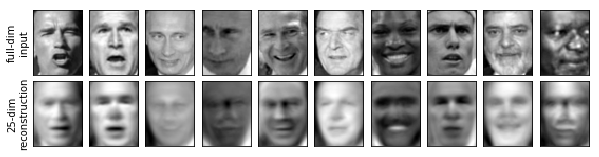

In [56]:
# Plot original faces and reconstructed faces
# Code slightly modified from the Python Data Science Handbook
fig, ax = plt.subplots(2, 10, figsize=(10, 2.5),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))
start = 700
for i in range(start, start+10):
    ax[0, i-start].imshow(X[i].reshape(62, 47), cmap='binary_r')
    # Substitute reconstructed face i (as a vector) for np.zeros(62*47)
    ax[1, i-start].imshow(x_reconstructed[i].reshape(62, 47), cmap='binary_r')

ax[0, 0].set_ylabel('full-dim\ninput')
ax[1, 0].set_ylabel('25-dim\nreconstruction')

** Exercise 18 **: Try fitting a PCA model with 170 components and creating a figure like the one above that compares the original images to the reconstructed images. Qualitatively, how close do the reconstructions come to the original images?

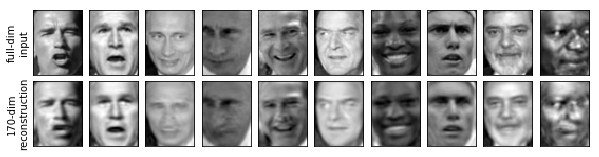

In [57]:
pca = PCA(n_components=170)
xproj = pca.fit_transform(X)
x_reconstructed = pca.inverse_transform(xproj)

fig, ax = plt.subplots(2, 10, figsize=(10, 2.5),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))
start = 700
for i in range(start, start+10):
    ax[0, i-start].imshow(X[i].reshape(62, 47), cmap='binary_r')
    # Substitute reconstructed face i (as a vector) for np.zeros(62*47)
    ax[1, i-start].imshow(x_reconstructed[i].reshape(62, 47), cmap='binary_r')

ax[0, 0].set_ylabel('full-dim\ninput')
ax[1, 0].set_ylabel('170-dim\nreconstruction')

## 3 Feature transformations
There are many useful ways in which you can transform your features, and how you should transform them depends on the context. In this section we will examine two common transformations and examples of when to use them. Let $x_1,\dots, x_n$ denote the inputs, $y_1,\dots, y_n$ denote the outputs (if there are any), and let $x_{ij}$ denote the $j$th feature of observation $i$.

### 3.1 Standardization
When we standardize a feature $j$ we compute $$ \frac{x_{ij} - \mu_j}{sd_j},$$
where $\mu_j$ is the mean of the $j$th feature across the observations and $sd_j$ is the corresponding standard deviation. Standardization is very commonly used because it puts all features on the same scale. This is useful for several reasons, including:
- In models with penalties on the coefficients, all features should be treated "equally", which can be done if the variables are on the same scale.
- Optimization algorithms tend to converge faster when the features are on the same scale.
- Models based on distances between features that are multi-dimensional tend to have lower error when the features are on the same scale.

Let's consider a very small nearest neighbors example. Suppose you have data on five people consisting of their wages and whether or not their employer provides them with a healthcare plan. The data for each person is summarized in the dataframe below. You want to find the person whose characteristics are most similar to a sixth person, whose healthplan status and wages are [1, 100005]. 

In [58]:
import pandas as pd

df = pd.DataFrame({'healthcare': [0, 1, 1, 0, 1], 'wages': [90000, 95000, 110000, 100010, 100015], })
X = df.as_matrix()
new_person = np.array([1, 100005]).reshape(1, -1)

Suppose we use 1-NN without standardizing the data. Then what do we find? That the fourth person is closest:

In [60]:
from sklearn.neighbors import NearestNeighbors
nn = NearestNeighbors(n_neighbors=1).fit(X)
nearest = nn.kneighbors(new_person)
print('Distance to nearest neighbor and index of nearest neighbor:', nearest)

Distance to nearest neighbor and index of nearest neighbor: (array([[ 5.09901951]]), array([[3]]))


But in reality, having a healthplan is much more valuable than getting paid $5 more. Therefore, we would want that the fifth person is most similar. We can obtain this outcome if we standardize the data:

In [61]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(X)
new_person = scaler.transform(new_person)
nn = NearestNeighbors(n_neighbors=1).fit(X)
nearest = nn.kneighbors(new_person.reshape(1, -1))
print('Distance to nearest neighbor and index of nearest neighbor:', nearest)

Distance to nearest neighbor and index of nearest neighbor: (array([[ 0.00150738]]), array([[4]]))


/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


### 3.2 Log transformation
A log transformation is where for feature $j$ you compute $\log(x_{ij})$ for all $i$ and use that instead of using $x_{ij}$ itself. A typical use case is for count data. Consider the case where you are classifying documents based on word counts. A word appearing once rather than not at all is much different than a word appearing 1000 times as opposed to 999 times. For this reason, we may choose to take the log of the word counts.